In [2]:
import json
import os 
import pandas as pd, numpy as np
import glob

def load_keypoints(fname, frame_no):
    '''Load OpenPose keypoints output
    Args:
      fname: filename of OpenPose output keypoints
      frame_no: frame number to be appended to file
  
    Returns: 
      Pandas dataframe that includes filename, inferred frameno, value, key, keyID.
    '''
    with open(fname) as json_file:
        data = json.load(json_file)
    # check if no_people different from number of unique people ids  
    no_people = len(data['people'])
    people_ids = [data['people'][i_people]['person_id'][0] for i_people in range(no_people)]
    if no_people != len(np.unique(people_ids)):
        people_ids = list(range(no_people))
    df = pd.DataFrame()
    for i_people in range(no_people):
        for key in data['people'][i_people].keys():
            value = data['people'][i_people][key]
            df = pd.concat([df, pd.DataFrame({'fname': fname, 'frame': frame_no, 'value': value, 'personID': people_ids[i_people] ,
                                            'key': key, 'keyID': [f"{key}_{str(i).zfill(3)}" for i in range(len(value))]
                                            })])
    return df.reset_index(drop=True)

# Load data

In [21]:
from tqdm import tqdm

In [ ]:
fnames = np.sort(glob.glob('output/json/*_keypoints.json'))
df = pd.DataFrame()
for fname in tqdm(fnames):
    frame_no = os.path.split(fname)[1].split('_')[1]
    df = pd.concat([df, load_keypoints(fname, frame_no = frame_no)],axis=0)

# Plot data in interactive widget

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, Layout

frames = df.frame.unique()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
frame = frames[0]
pose = df.query(f"key=='pose_keypoints_2d' and personID==0 and frame==@frame").value
# 75 data points in (x1,y1,c1, x2,y2,c2,...) where x is x coord, y is y coord, and c is confidence 
xs = pose[::3].values
ys = pose[1::3].values

ax.scatter(xs,ys)
plt.axis('scaled')
ax.set(xlim=[0,640],ylim=[0,480])
plt.gca().invert_yaxis()

def update(w = 0, _w=0):
    frame = frames[w]
    pose = df.query(f"key=='pose_keypoints_2d' and frame==@frame").value
    xs = pose[::3].values
    ys = pose[1::3].values
    ax.clear()
    ax.scatter(xs,ys)
    plt.axis('scaled')
    ax.set(xlim=[0,640],ylim=[0,480])
    plt.gca().invert_yaxis()
    fig.canvas.draw_idle()

play = widgets.Play(
#     interval=10,
    value=0, min=0, max=len(frames), step=1, description="Press play",    disabled=False)
slider = widgets.IntSlider(value=0, min=0, max=len(frames), step=1, layout=Layout(width='50%', height='80px'))
widgets.jslink((play, 'value'), (slider, 'value'))
widgets.HBox([play, slider])
interact(update, w = slider, _w = play);

# Extract some features

In [214]:
from scipy.spatial.distance import cdist, squareform

def grab_pose(df):
    '''Grabs the pose_keypoints_2d
    Args:
        df: Keypoints dataframe
    Returns: 
        pose_keypoints_2d: pandas dataframe
    '''
    return df.query(f"key=='pose_keypoints_2d'")

def grab_people(df):
    '''Grabs the number of people in each frame
    Args: 
        df: Keypoints dataframe
    Returns: 
        person_counts: pandas series
    '''
    def len_unique(x): return len(x)
    person_counts = pd.pivot_table(df.query('key=="person_id"'), aggfunc=len_unique, index='frame')['value']
    return person_counts

def grab_person_pose(df, personID):
    '''Grabs the pose keypoint data for specified personid.
    Args:
        df: Keypoints pose dataframe.  
    Returns:
        Dataframe for specified personID
    '''
    return df.query('personID==@personID').pivot(index='frame',columns='keyID',values='value')
    
def extract_distance(person_df, metric='euclidean'):
    '''Extracts distance matrix for each keypoint at each index.
    Args:
        person_df: frame x 75 column keypoint dataframe. 
        metric: distance metric used in scipy.spatial.distance.cdist (default: euclidean)
    Returns: 
        Dataframe with frame x keypoint distance matrix
    '''
    pose_dms = []
    for frame_ix in range(len(person_df)):
        p_x = person_df.iloc[frame_ix,:72:3]
        p_y = person_df.iloc[frame_ix,1:72:3]
        pose_dms.append(squareform(cdist(np.array([p_x, p_y]).T,np.array([p_x, p_y]).T, metric=metric)))
    return pd.DataFrame(pose_dms,index=person_df.index)

def filter_pose_confidence(pose_df, min_conf=.2, filter_func = np.mean):
    '''Filter pose_2d keypoints by confidence. 
    Args:
        pose_df: pose_2d dataframe
        min_conf: minimum confidence per frame to remove
        filter_func: function to filter confidence per frame (default: np.mean)
    Return:
        filtered Dataframe
    '''
    filter_bool = []
    for frame_ix in range(len(person_df)):
        p_c = person_df.iloc[frame_ix,2:72:3]
        filter_bool.append(filter_func(p_c) > min_conf)
    return person_df.loc[filter_bool]

In [215]:
# Filter just the pose data. 
pose2d = grab_pose(df)
# Grab 1 person's pose by personID
person_df = grab_person_pose(pose2d, personID=0)
# Filter by confidence 
person_df_filtered = filter_pose_confidence(person_df)
# Extract distance from one person pose df 
pose_dm = extract_distance(person_df)
# plot sample rdm with scatterplot

<IPython.core.display.Javascript object>


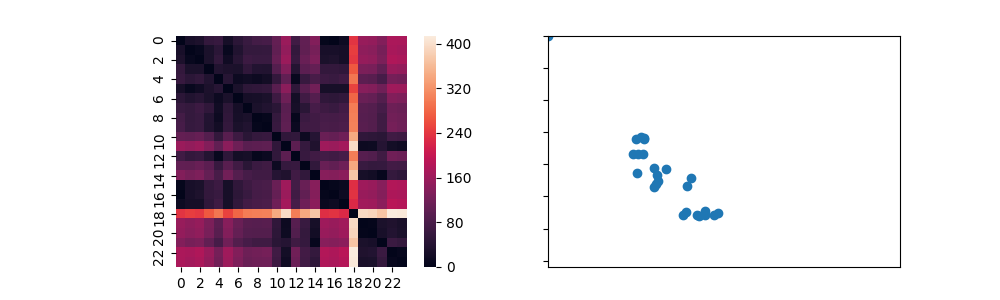

(360.0, 0.0)

In [249]:
frame_ix = 350
frame = pose_dm.index[frame_ix]

_df = person_df[person_df.index==frame]
xs = _df.iloc[0,::3]
ys = _df.iloc[0,1::3]

f,axes = plt.subplots(1,2,figsize=(10,3))
sns.heatmap((squareform(pose_dm.iloc[frame_ix])), ax=axes[0], square=True)
axes[1].scatter(xs,ys)
axes[1].axes.set_xscale('linear')
axes[1].axes.set_yscale('linear')
axes[1].set(xlim=[0,640], ylim=[0,360], xticks=[], xticklabels=[], yticklabels=[])
axes[1].set_ylim(axes[1].get_ylim()[::-1])

In [53]:
# grabs pose data from every person
# TODO: filter by confidence
# TODO: Based on person count
pose2d = grab_pose(df)

In [65]:
person_count = person_counts==2
person_count = person_count.to_dict()
pose2d['person_count'] = pose2d.frame.map(person_count)
# grab just the pose when there is two people
pose2d_2p = pose2d.query('person_count==True')

/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [67]:
pose2p_dict = {}
for personID in pose2d_2p.personID.unique():
    pose2p_dict[personID] = pose2d_2p.query('personID==@personID')

In [74]:
p0 = pose2p_dict[0].pivot(index='frame',columns='keyID',values='value')
p1 = pose2p_dict[1].pivot(index='frame',columns='keyID',values='value')

<IPython.core.display.Javascript object>


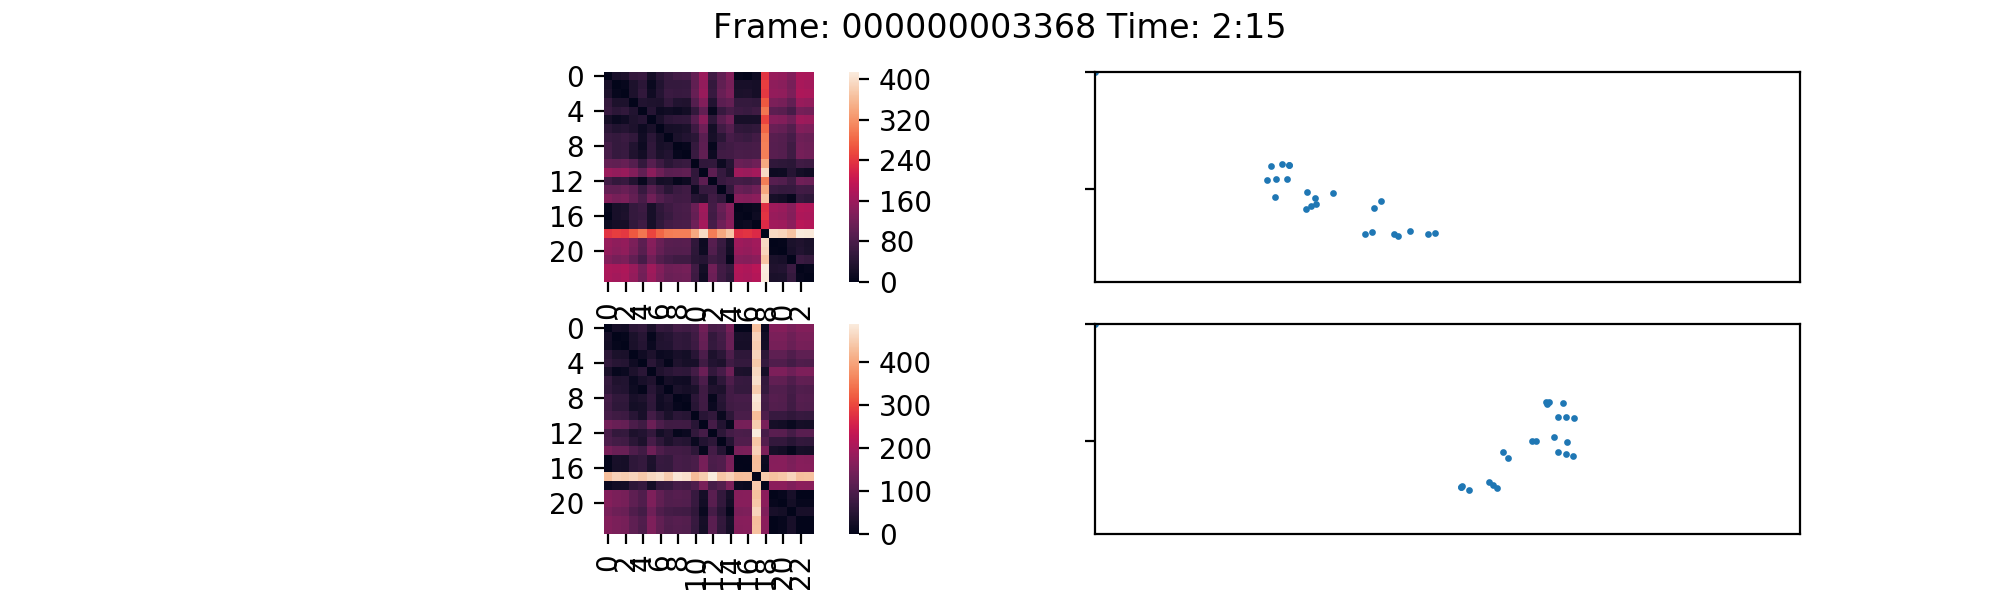

Text(0.5,0.98,'Frame: 000000003368 Time: 2:15')

In [186]:
# ignore background which is the last three
frame_ix = 210 # 210
f,axes = plt.subplots(2,2, figsize=(10,3))
for p_i, p in enumerate([p0,p1]):
    ax = axes[p_i]
    p_x = p.iloc[frame_ix,:72:3]
    p_y = p.iloc[frame_ix,1:72:3]
    pose_dm = cdist(np.array([p_x, p_y]).T,np.array([p_x, p_y]).T)
    sns.heatmap(pose_dm, ax=axes[p_i,0], square=True)
    axes[p_i,1].scatter(p_x,p_y, s=2)
    axes[p_i,1].axes.set_xscale('linear')
    axes[p_i,1].axes.set_yscale('linear')
    axes[p_i,1].set(xlim=[0,640], ylim=[0,360], xticks=[], xticklabels=[], yticklabels=[])
    axes[p_i,1].set_ylim(axes[p_i,1].get_ylim()[::-1])
    
fps = 25.
time = int(p.index[frame_ix])/fps/60.
time_min = int(np.floor(time))
time_sec = int(np.round(60*float(str(time-int(time))[1:])))
plt.suptitle(f"Frame: {p.index[frame_ix]} Time: {time_min}:{time_sec}")

In [187]:
from scipy.spatial.distance import cdist, squareform
import seaborn as sns


In [50]:
person_pose = pose2d.query("personID==-1").pivot(index='frame', columns='keyID', values='value')

<IPython.core.display.Javascript object>


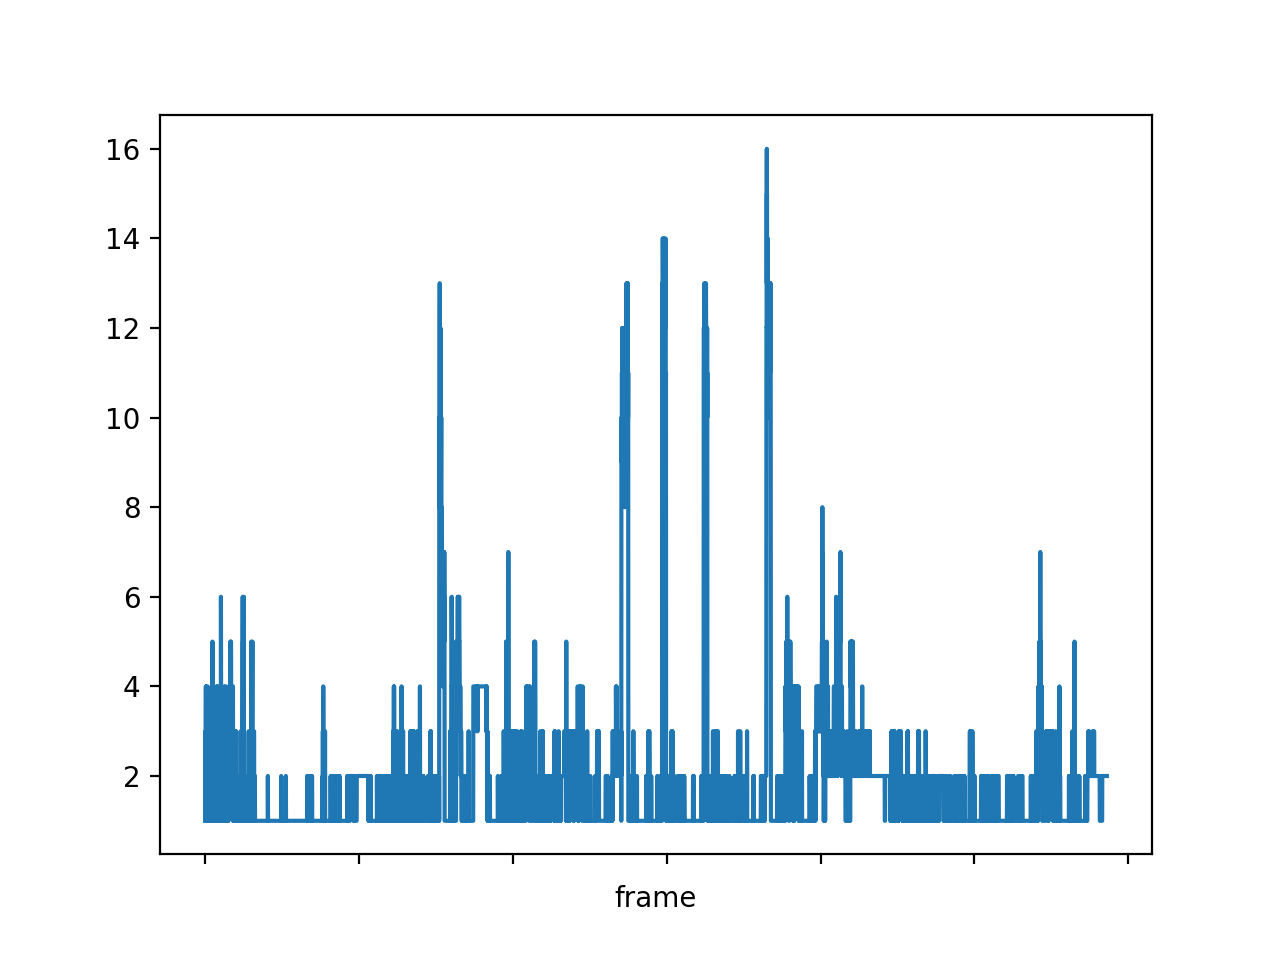

In [52]:
person_counts = grab_people(df)
person_counts.plot()